In [1]:
################################################
###
### test SH decomposition with Hannah organoid data
###
################################################

In [1]:
from skimage import measure
import pandas as pd
from skimage.filters import threshold_otsu, rank
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import pyshtools as pysh

In [3]:
from skimage.io import imread
from skimage.io import imsave
from skimage import filters
from skimage import morphology
from pyclesperanto_prototype import imshow
import pyclesperanto_prototype as cle
import matplotlib.pyplot as plt

In [4]:
import napari
from napari.utils import nbscreenshot

In [5]:
cle.available_device_names()

['Apple M1 Max']

In [6]:
# For 3D processing, powerful graphics
# processing units might be necessary
cle.select_device('TX')

/Users/jingkui.wang/miniforge3/envs/image_env/lib/python3.9/site-packages/pyclesperanto_prototype/_tier0/_device.py:77: UserWarning: No OpenCL device found with TX in their name. Using Apple M1 Max instead.
  warnings.warn(f"No OpenCL device found with {name} in their name. Using {device.name} instead.")


<Apple M1 Max on Platform: Apple (2 refs)>

In [7]:
### import function https://github.com/gioda/FeARLesS/blob/main/Fearless/utils.py
import pyshtools
import gc
import numpy as np
import os
from vedo import printc, spher2cart, probePoints

#from vedo import Points
import shutil
from sys import exit
#from vedo import spher2cart
#from vedo import printc, spher2cart, probePoints

In [8]:
def samplePoints(vol, expo, N, radiusDiscretisation):
    """Compute sample points."""
    pos = vol.center()
    rmax = vol.diagonalSize()/2

    samplePoints = []
    for th in np.linspace(0, np.pi, N, endpoint=False):
        for ph in np.linspace(0, 2*np.pi, N, endpoint=False):

            # compute sample points
            p = spher2cart(rmax, th, ph)
            # making discretization more dense away from the center
            p_tmp = p / (radiusDiscretisation-1)**expo
            for j in range(radiusDiscretisation):
                SP = pos + p_tmp * (j**expo)
                samplePoints.append(SP)

    del vol
    return np.array(samplePoints)

def confirm(message):
    """
    Ask user to enter Y or N (case-insensitive).

    :return: True if the answer is Y.
    :rtype: bool
    """
    answer = ""
    while answer not in ["y", "n"]:
        answer = input(message).lower()
    return answer == "y"


def pathExists(path):
    if not os.path.exists(path):
        os.makedirs(path, exist_ok=True)
        printc("Directory ", path, " Created ", c='green')
    else:
        printc("Directory ", path, " already exists", c='red')
        if confirm("Should I delete the folder and create a new one [Y/N]? "):
            shutil.rmtree(path)
            os.makedirs(path, exist_ok=True)
            printc("Directory ", path, " Created ", c='green')
        else:
            exit()


def voxelIntensity(vol, expo, N, radiusDiscretisation):
    """Compute voxel intensities."""
    pos = vol.center()
    rmax = vol.diagonalSize()/2

    scalars = []

    for th in np.linspace(0, np.pi, N, endpoint=False):
        for ph in np.linspace(0, 2*np.pi, N, endpoint=False):

            # compute sample points
            p = spher2cart(rmax, th, ph)
            samplePointsTmp = []
            
            # making discretization more dense away from the center
            p_tmp = p / (radiusDiscretisation-1)**expo
            for j in range(radiusDiscretisation):
                SP = pos + p_tmp * (j**expo)
                samplePointsTmp.append(SP)

            # compute intensities
            pb = probePoints(vol, samplePointsTmp)

            del samplePointsTmp

            # making the intensities growing outside the volume according to the gradient
            scalarsTmp = pb.getPointArray()
            nonz = np.nonzero(scalarsTmp)[0]
            if len(nonz) > 2:
                lastNoZeroId = nonz[-1]  # find the last value != 0
                secondlastNoZeroId = nonz[-2]
                # find the last value != 0
                lastNoZero = scalarsTmp[lastNoZeroId]
                secondlastNoZero = scalarsTmp[secondlastNoZeroId]
                dx = lastNoZero - secondlastNoZero

            for i in range(lastNoZeroId+1, len(scalarsTmp)):
                scalarsTmp[i] = scalarsTmp[i-1] + dx
            scalars.append(scalarsTmp.tolist())

            del pb, scalarsTmp

    del vol
    gc.collect()

    # return allIntensitiesMatrix
    return np.array(scalars).reshape((N * N, radiusDiscretisation))


def forwardTransformation(matrixOfIntensities, N, lmax):

    ##############################################

    coeff = matrixOfIntensities

    ##############################################
    # SPHARNM
    allClm = np.zeros((matrixOfIntensities.shape[1], 2, lmax, lmax))
    for j in range(allClm.shape[0]):
        formattedcoeff = np.reshape(coeff[:, j], (N, N))
        SH = pyshtools.SHGrid.from_array(formattedcoeff)
        clm = SH.expand()

        allClm[j, :, :, :] = clm.to_array(lmax=lmax - 1)

    del formattedcoeff, clm, matrixOfIntensities

    return allClm


def inverseTransformations(allClm, allIntensitiesShape, N, lmax):
    """Make inverse SPHARM."""
    from scipy.interpolate import griddata

    aSH_recoMatrix = np.zeros((allIntensitiesShape[0], allIntensitiesShape[1]))

    for j in range(allClm.shape[0]):
        # inverse SPHARM coefficients
        clmCoeffs = pyshtools.SHCoeffs.from_array(allClm[j, :, :, :])
        SH_reco = clmCoeffs.expand(lmax=lmax - 1)
        # grid_reco.plot()
        aSH_reco = SH_reco.to_array()

        ##############################
        pts1 = []
        ll = []
        for ii, long in enumerate(np.linspace(0, 360, num=aSH_reco.shape[1], endpoint=True)):
            for jj, lat in enumerate(np.linspace(90, -90, num=aSH_reco.shape[0], endpoint=True)):
                th = np.deg2rad(90 - lat)
                ph = np.deg2rad(long)
                p = spher2cart(aSH_reco[jj][ii], th, ph)
                pts1.append(p)
                ll.append((lat, long))

        radii = aSH_reco.T.ravel()

        # make a finer grid
        n = N * 1j
        l_min, l_max = np.array(ll).min(axis=0), np.array(ll).max(axis=0)
        grid = np.mgrid[l_max[0]:l_min[0]:n, l_min[1]:l_max[1]:n]
        grid_x, grid_y = grid
        agrid_reco_finer = griddata(ll, radii, (grid_x, grid_y), method='cubic')
        ##############################

        formatted_aSH_reco = np.reshape(agrid_reco_finer, (N * N))

        aSH_recoMatrix[:, j] = formatted_aSH_reco

    del formatted_aSH_reco, agrid_reco_finer, grid_x, grid_y, grid

    return aSH_recoMatrix


In [9]:
from sys import argv, exit
import numpy as np
import pyshtools

from vedo import printc, load, spher2cart, mag, ProgressBar, Points, write
from vedo import *

from skimage.io import imread
from skimage.io import imsave
#from skimage import filters
#from skimage import morphology
#from pyclesperanto_prototype import imshow
#import pyclesperanto_prototype as cle
#import matplotlib.pyplot as plt

#from scipy.interpolate import griddata

In [10]:
def computeCLM(mesh, rmax, N, x0):
    """Compute CLM."""
    # cast rays from the center and find intersections
    agrid, pts = [], []
    for th in np.linspace(0, np.pi, N, endpoint=False):
        lats = []
        for ph in np.linspace(0, 2*np.pi, N, endpoint=False):
            p = spher2cart(rmax, th, ph)
            intersections = mesh.intersect_with_line(x0, x0 + p)
            if len(intersections):
                value = mag(intersections[0]-x0)
                lats.append(value)
                pts.append(intersections[0])
            else:
                lats.append(rmax)
                # lats.append(0)
                pts.append(p)
        agrid.append(lats)
    agrid = np.array(agrid)

    grid = pyshtools.SHGrid.from_array(agrid)
    clm = grid.expand()
    # grid_reco = clm.expand(lmax=lmax)  # cut "high frequency" components

    return clm

In [11]:
lmax = 20
N = 500          # number of grid intervals on the unit sphere
rmax = 1400
x0 = [0, 0, 0]  # set object at this position
xLimb = [-200, 0, 200]
cutOrigin = [150, 0, 0]
deg_fit = 6

In [12]:
CPoutDir = "/Volumes/groups/tanaka/People/current/jiwang/projects/RA_competence/images_data/test_WTd6"
WTDir = "/Volumes/groups/tanaka/People/current/jiwang/projects/RA_competence/images_data/test_WTd6" 

#CPoutDir = "/Volumes/groups/tanaka/People/current/jiwang/projects/RA_competence/images_data/CPouts2"
#ImageDir = "/Volumes/groups/tanaka/People/current/jiwang/projects/RA_competence/images_data/d4_10x_Pax6KO_WTchim" 

In [13]:
#DataPath = '/Users/jingkui.wang/workspace/imp/image_analysis/S-BIAD441/limbs/limbs-noFlank/'
path_results = 'res/' \
        + 'test_organoid_WTd6' + '/'

#pathExists(path_results)

printc('lmax =', lmax, 'N =', N, 'deg_fit =', deg_fit, c='y')

lmax = 20 N = 500 deg_fit = 6


In [15]:
outDir = path_results

In [16]:
fileName = '20220727_d6_10x_RA-18h_E2_121_1981_isotropic'
#fileName = '241023_10x_d4-2umZ_4-PS-WG_RA_FA2-Px6_F9_95_01_isotropic'

In [17]:
mask = imread(os.path.join(CPoutDir, str(fileName + "_C4_CystMask.tiff"))) # mask segmeted cysts
C3 = imread(os.path.join(WTDir, str(fileName + "_C3.tif"))) # FoxA2, nuclei
C2 = imread(os.path.join(WTDir, str(fileName + "_C2.tif"))) # Pax6, nuclei
C4 = imread(os.path.join(WTDir, str(fileName + "_C4.tif"))) # Dapi, nuclei

C3 = C3 / np.quantile(C3, 0.95)
C2 = C2 / np.quantile(C2, 0.95)
C4 = C4 / np.quantile(C4, 0.95)

In [17]:
#mask = imread(os.path.join(CPoutDir, str(fileName + "_C5_CystMask.tiff"))) # mask segmeted cysts
#C1 = imread(os.path.join(CPoutDir, str(fileName + "_FoxA2mask.tiff"))) # FoxA2, nuclei
#C2 = imread(os.path.join(CPoutDir, str(fileName + "_P6KOSCmask.tiff"))) # Pax6-KO genotype Scarlet, nuclei
#C3 = imread(os.path.join(CPoutDir, str(fileName + "_WTGFPmask.tiff"))) # WT genotype GFP, whole cell 
#C4 = imread(os.path.join(CPoutDir, str(fileName + "_Pax6mask.tiff"))) # Pax6, nuclei
#C1 = imread(os.path.join(ImageDir, str(fileName + "_C1.tif"))) # FoxA2, nuclei
#C2 = imread(os.path.join(ImageDir, str(fileName + "_C2.tif"))) # Pax6-KO genotype Scarlet, nuclei
#C3 = imread(os.path.join(ImageDir, str(fileName + "_C3.tif"))) # WT genotype GFP, whole cell 
#C4 = imread(os.path.join(ImageDir, str(fileName + "_C4.tif"))) # Pax6, nuclei
#C1 = C1 / np.quantile(C1, 0.99)
#C2 = C2 / np.quantile(C2, 0.99)
#C3 = C3 / np.quantile(C3, 0.99)
#C4 = C4 / np.quantile(C4, 0.99)

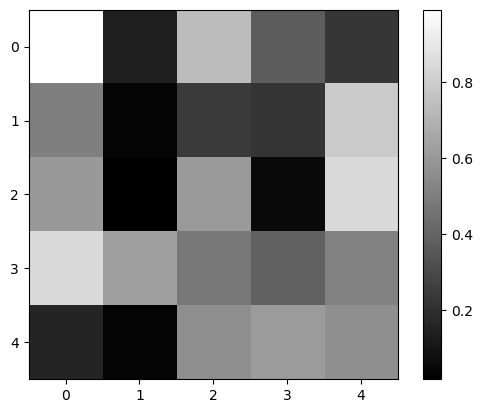

In [18]:
## test the image data structure in skimage
## for volumetric (3D) images, we refer to the leading dimension as plane, abbreviated as pln or p.
## 3D grayscale the numpy data structure is: (plane, row, column)

random_image = np.random.random([5, 5])
plt.imshow(random_image, cmap='gray')
plt.colorbar();

In [19]:
random_image 

array([[0.99061212, 0.13870748, 0.7341107 , 0.37449883, 0.22606316],
       [0.50410548, 0.03584999, 0.24163755, 0.21626788, 0.78784254],
       [0.60273162, 0.01859165, 0.60377445, 0.05381851, 0.84515272],
       [0.8469892 , 0.62347188, 0.47645795, 0.39405739, 0.51451806],
       [0.15880539, 0.03677827, 0.55864166, 0.61066329, 0.56502042]])

In [20]:
from skimage import measure
import pandas as pd
from skimage.filters import threshold_otsu, rank
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [21]:
labels_mask, nb_cyst = measure.label(mask, return_num = True)

In [22]:
#from skimage.measure import label, regionprops
#props = regionprops(labels_mask)
#props
#props[0].pixelcount

In [23]:
nb_cyst

29

In [182]:
cyst_index = np.where(labels_mask == 10)
cyst_index[0].size
#genotype_wt = C3[cyst_index]
#genotype_ko = C2[cyst_index]

95612

In [183]:
#cyst_index[0].size

In [168]:
viewer = napari.Viewer()

# show images
viewer.add_image(cle.pull(C3))
viewer.add_labels(cle.pull(labels_mask))


<Labels layer 'labels_mask' at 0x38e9c30a0>

In [184]:
cyst_index = 10
[z, rows, columns] = np.where(labels_mask == cyst_index)
z1 = min(z)
z2 = max(z)
row1 = min(rows)
row2 = max(rows)
col1 = min(columns)
col2 = max(columns)

In [185]:
xx = np.where(labels_mask == cyst_index, C3, 0)
newImage_foxa2 = xx[z1:z2, row1:row2, col1:col2]

xx = np.where(labels_mask == cyst_index, C4, 0)
newImage_dapi = xx[z1:z2, row1:row2, col1:col2]

xx = np.where(labels_mask == cyst_index, labels_mask, 0)
newImage_cyst = xx[z1:z2, row1:row2, col1:col2]



In [187]:
newImage_cyst.shape
print(newImage_foxa2.min())
print(newImage_foxa2.max())
print(newImage_dapi.min())
print(newImage_dapi.max())

0
4049
0
14142


In [188]:
imsave(os.path.join(outDir, str(fileName + "_cyst_2_channel_FoxA2.tif")), newImage_foxa2)
imsave(os.path.join(outDir, str(fileName + "_cyst_2_channel_dapi.tif")), newImage_dapi)

/var/folders/ld/7f_9j5n17vs69r90p179ws240000gp/T/ipykernel_67569/1337608745.py:1: UserWarning: res/test_organoid_WTd6/20220727_d6_10x_RA-18h_E2_121_1981_isotropic_cyst_2_channel_FoxA2.tif is a low contrast image
  imsave(os.path.join(outDir, str(fileName + "_cyst_2_channel_FoxA2.tif")), newImage_foxa2)


In [189]:
outDir

'res/test_organoid_WTd6/'

In [190]:
viewer = napari.Viewer()
# show images
viewer.add_image(cle.pull(newImage_cyst))
viewer.add_image(cle.pull(newImage_foxa2))
viewer.add_image(cle.pull(newImage_dapi))

<Image layer 'newImage_dapi' at 0x466cdbf70>

In [ ]:
## from here test the code from fearless

In [191]:
from vedo import printc, load, ProgressBar
#from utils import pathExists, voxelIntensity
import numpy as np

In [192]:
radiusDiscretisation = 50
N = 250
FFTexpansion = radiusDiscretisation
expo = 1.0

In [193]:
newImage_dapi.shape

(53, 61, 59)

In [194]:
vol_dapi = load(os.path.join(outDir, str(fileName + "_cyst_2_channel_dapi.tif")))
vol_foxa2 = load(os.path.join(outDir, str(fileName + "_cyst_2_channel_FoxA2.tif")))

In [46]:
pos = vol_dapi.center()
rmax = vol_dapi.diagonalSize()/2
pos, rmax, N, radiusDiscretisation

(array([20., 23., 24.]), 38.79432948254165, 250, 50)

In [212]:
mesh = Sphere(pos=pos, r=rmax, c='r5', res=24)
show(mesh)
#show(vol_obj, arrs+arrs_pts_probe, N=2, axes=1).close()

AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [202]:
show(vol_foxa2)

AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [204]:
scalars = []

In [205]:
np.linspace(0, np.pi, N, endpoint=False);
np.linspace(0, 2*np.pi, N, endpoint=False);
th = np.linspace(0, np.pi, N, endpoint=False)[100]
ph = np.linspace(0, 2*np.pi, N, endpoint=False)[20]
th, ph

(1.2566370614359172, 0.5026548245743669)

In [228]:
p = spher2cart(rmax, th, ph)
p,pos

(array([  2.41670818,  -0.30530124, -38.71777774]), array([20., 23., 24.]))

In [229]:
p_tmp = p / (radiusDiscretisation-1)**expo

samplePointsTmp = []
for j in range(radiusDiscretisation):
    SP = pos + p_tmp * (j**expo) # pos is the center, 
    samplePointsTmp.append(SP)

len(samplePointsTmp), p, p_tmp, (radiusDiscretisation-1)**expo

(20,
 array([  2.41670818,  -0.30530124, -38.71777774]),
 array([ 0.12719517, -0.01606849, -2.03777778]),
 19.0)

In [230]:
samplePointsTmp;

In [231]:
pb = probePoints(vol_foxa2, samplePointsTmp)
#del samplePointsTmp
scalarsTmp = pb.getPointArray()
scalarsTmp

array([395, 406, 401, 385, 361, 335, 292, 263, 240,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0], dtype=uint16)

In [232]:
scalarsTmp = pb.getPointArray()

nonz = np.nonzero(scalarsTmp)[0]
scalarsTmp;
nonz

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [233]:
lastNoZeroId = nonz[-1]  # find the last value != 0
secondlastNoZeroId = nonz[-2]
lastNoZeroId, secondlastNoZeroId

(8, 7)

In [234]:
lastNoZero = scalarsTmp[lastNoZeroId]
secondlastNoZero = scalarsTmp[secondlastNoZeroId]
dx = lastNoZero - secondlastNoZero
lastNoZero,secondlastNoZero

/var/folders/ld/7f_9j5n17vs69r90p179ws240000gp/T/ipykernel_67569/307586485.py:3: RuntimeWarning: overflow encountered in scalar subtract
  dx = lastNoZero - secondlastNoZero


(240, 263)

In [236]:
scalarsTmp.max().tolist()

406

In [ ]:
 #nonz = np.nonzero(scalarsTmp)[0]
if len(nonz) > 2:
    lastNoZeroId = nonz[-1]  # find the last value != 0
    secondlastNoZeroId = nonz[-2]
    # find the last value != 0
    lastNoZero = scalarsTmp[lastNoZeroId]
    secondlastNoZero = scalarsTmp[secondlastNoZeroId]
    dx = lastNoZero - secondlastNoZero

        for i in range(lastNoZeroId+1, len(scalarsTmp)):
            scalarsTmp[i] = scalarsTmp[i-1] + dx
        
        scalars.append(scalarsTmp.tolist())

In [326]:
N = 100; radiusDiscretisation = 50

In [327]:
#scalarsTmp.max()

In [328]:
"""Compute voxel intensities."""
scalars = []
for th in np.linspace(0, np.pi, N, endpoint=False):
    for ph in np.linspace(0, 2*np.pi, 2*N, endpoint=False):
        
        # compute sample points
        p = spher2cart(rmax, th, ph)
        
        samplePointsTmp = []
        # making discretization more dense away from the center
        p_tmp = p / (radiusDiscretisation-1)**expo
        for j in range(radiusDiscretisation):
            SP = pos + p_tmp * (j**expo)
            samplePointsTmp.append(SP)

        # compute intensities
        pb = probePoints(vol_foxa2, samplePointsTmp)
        
        del samplePointsTmp

        # making the intensities growing outside the volume according to the gradient
        scalarsTmp = pb.getPointArray()
        #nonz = np.nonzero(scalarsTmp)[0]
        #print(scalarsTmp)
        
        #if len(nonz) > 2:
        #    lastNoZeroId = nonz[-1]  # find the last value != 0
        #    secondlastNoZeroId = nonz[-2]
        #    # find the last value != 0
        #    lastNoZero = scalarsTmp[lastNoZeroId]
        #    secondlastNoZero = scalarsTmp[secondlastNoZeroId]
        #    dx = lastNoZero - secondlastNoZero

        #for i in range(lastNoZeroId+1, len(scalarsTmp)):
        #    scalarsTmp[i] = scalarsTmp[i-1] + dx
        
        scalars.append(scalarsTmp.max())
        del pb, scalarsTmp

    #del vol
    #gc.collect()

    # return allIntensitiesMatrix
    #return np.array(scalars).reshape((N * N, radiusDiscretisation))

In [329]:
len(scalars)

20000

In [330]:
matrixOfIntensities = np.array(scalars)

In [331]:
matrixOfIntensities
coeff = matrixOfIntensities

In [332]:
len(matrixOfIntensities)

20000

In [318]:
#coeff = matrixOfIntensities
##############################################
# SPHARNM
#allClm = np.zeros((matrixOfIntensities.shape[1], 2, lmax, ))

IndexError: tuple index out of range

In [333]:
formattedcoeff = np.reshape(coeff, (N, N*2))
formattedcoeff

array([[397, 397, 397, ..., 397, 397, 397],
       [396, 396, 396, ..., 396, 396, 396],
       [396, 396, 396, ..., 396, 396, 396],
       ...,
       [406, 406, 406, ..., 405, 406, 406],
       [406, 406, 406, ..., 406, 406, 406],
       [407, 407, 407, ..., 407, 407, 407]], dtype=uint16)

[Text(0.5, 0, 'theta'), Text(0, 0.5, 'phi')]

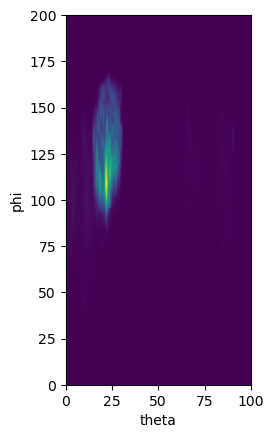

In [335]:
fig, ax = plt.subplots(1, 1)
ax.imshow(formattedcoeff, extent=(0, N, 0, N))
ax.set(xlabel='theta', ylabel='phi')
#ax.minorticks_on()

[Text(0.5, 0, 'theta'), Text(0, 0.5, 'phi')]

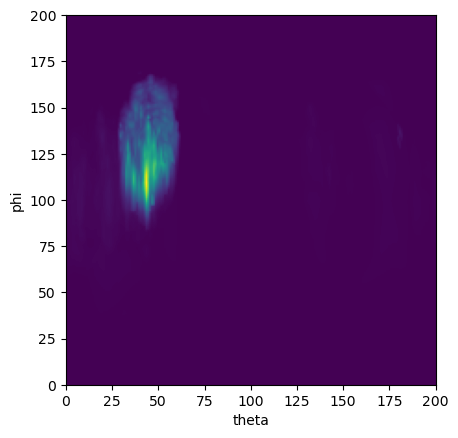

In [321]:
formattedcoeff_norm = formattedcoeff - formattedcoeff.mean()
fig, ax = plt.subplots(1, 1)
ax.imshow(formattedcoeff_norm, extent=(0, N, 0, N))
ax.set(xlabel='theta', ylabel='phi')
#ax.minorticks_on()

In [322]:
formattedcoeff_norm

array([[-55.600325, -55.600325, -55.600325, ..., -55.600325, -55.600325,
        -55.600325],
       [-55.600325, -55.600325, -55.600325, ..., -55.600325, -55.600325,
        -55.600325],
       [-55.600325, -55.600325, -55.600325, ..., -55.600325, -55.600325,
        -55.600325],
       ...,
       [-43.600325, -43.600325, -43.600325, ..., -43.600325, -43.600325,
        -43.600325],
       [-43.600325, -43.600325, -43.600325, ..., -43.600325, -43.600325,
        -43.600325],
       [-42.600325, -42.600325, -42.600325, ..., -42.600325, -42.600325,
        -42.600325]])

In [336]:
SH = pyshtools.SHGrid.from_array(formattedcoeff_norm, grid = "DH")
clm = SH.expand(lmax_calc= 10)
grid_reco = clm.expand(lmax=10).to_array()  # cut "high frequency" components

In [337]:
grid_reco

array([[-28.7127273 , -28.7127273 , -28.7127273 , ..., -28.7127273 ,
        -28.7127273 , -28.7127273 ],
       [-21.47528293, -25.03923048, -30.26184038, ..., -20.28827708,
        -19.87761282, -21.47528293],
       [-15.74663511, -27.2566197 , -45.13829443, ..., -17.20616385,
        -12.48090601, -15.74663511],
       ...,
       [-59.5572788 , -59.54282245, -57.90861136, ..., -54.03301082,
        -57.64744421, -59.5572788 ],
       [-55.85192362, -57.99861764, -59.76071815, ..., -50.60779115,
        -53.35593311, -55.85192362],
       [-52.42076167, -52.42076167, -52.42076167, ..., -52.42076167,
        -52.42076167, -52.42076167]])

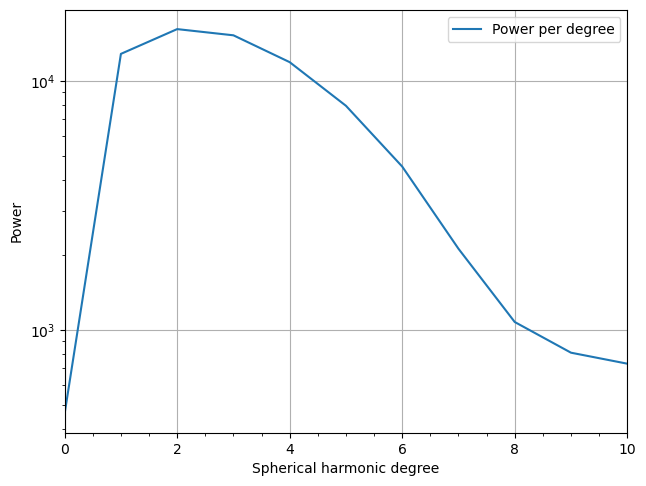

In [338]:
fig, ax = clm.plot_spectrum(show=False) 

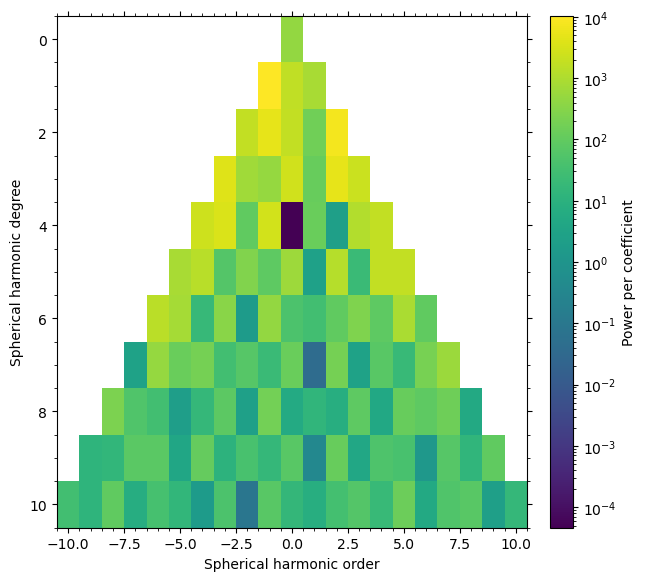

In [342]:
fig, ax = clm.plot_spectrum2d(show=False)

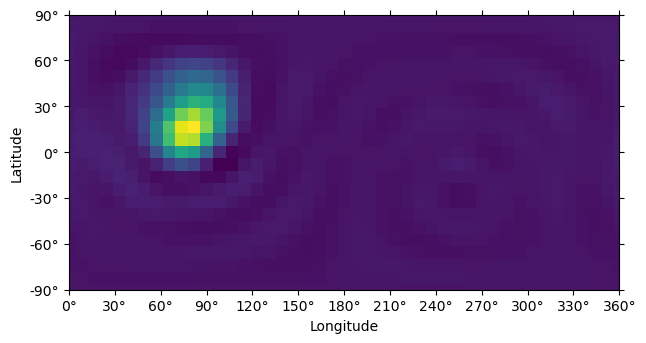

In [343]:
grid = clm.expand()
fig, ax = grid.plot(show=False)

In [301]:
SH = pyshtools.SHGrid.from_array(formattedcoeff, grid = "DH")
grid_SH = SH.expand(grid='DH2')
fig, ax = grid_SH.plot(show=False)

TypeError: expand() got an unexpected keyword argument 'grid'

In [281]:
power_per_l = pyshtools.spectralanalysis.spectrum(SH)


TypeError: 'DHRealGrid' object is not subscriptable

In [297]:
## make a test for degree
lmax = 200
coeffs = np.zeros((2, lmax+1, lmax+1))
coeffs[0, 5, 2] = 1.
coeffs_l5m2 = pysh.SHCoeffs.from_array(coeffs)
#coeffs_l5m2 = .expand(lmax_calc= 10)

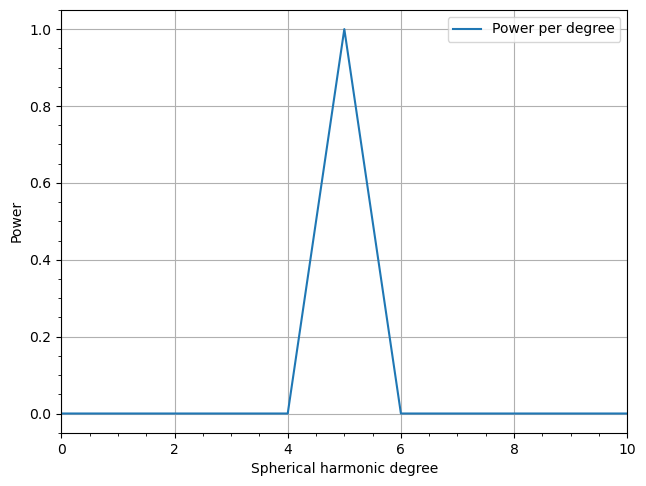

In [298]:
fig, ax = coeffs_l5m2.plot_spectrum(xscale='lin', yscale='lin',  lmax = 10, show=False)

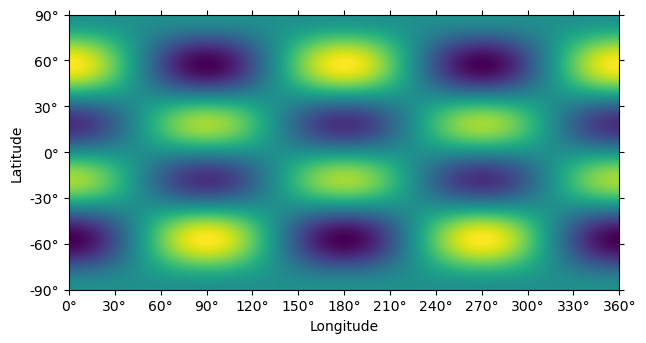

In [300]:
grid_l5m2 = coeffs_l5m2.expand(grid='DH')
fig, ax = grid_l5m2.plot(show=False)

In [302]:
grid_l5m2

  name = None
  kind = 'real'
  grid = 'DH'
  n = 402
  sampling = 1
  extend = True
  nlat = 403
  nlon = 403
  lmax = 200
  units = None

In [158]:
#test = newImage_cyst/newImage_cyst.max() +  newImage_foxa2
test = newImage_dapi + newImage_foxa2

In [161]:
viewer = napari.Viewer()

# show images
viewer.add_image(cle.pull(newImage_cyst))
viewer.add_image(cle.pull(newImage_foxa2))
viewer.add_image(cle.pull(newImage_dapi))
viewer.add_image(cle.pull(test))


<Image layer 'test' at 0x319419df0>

In [159]:
# Use marching cubes to obtain the surface mesh of these ellipsoids
verts, faces, normals, values = measure.marching_cubes(volume = test, step_size = 1)

(0.0, 50.0)

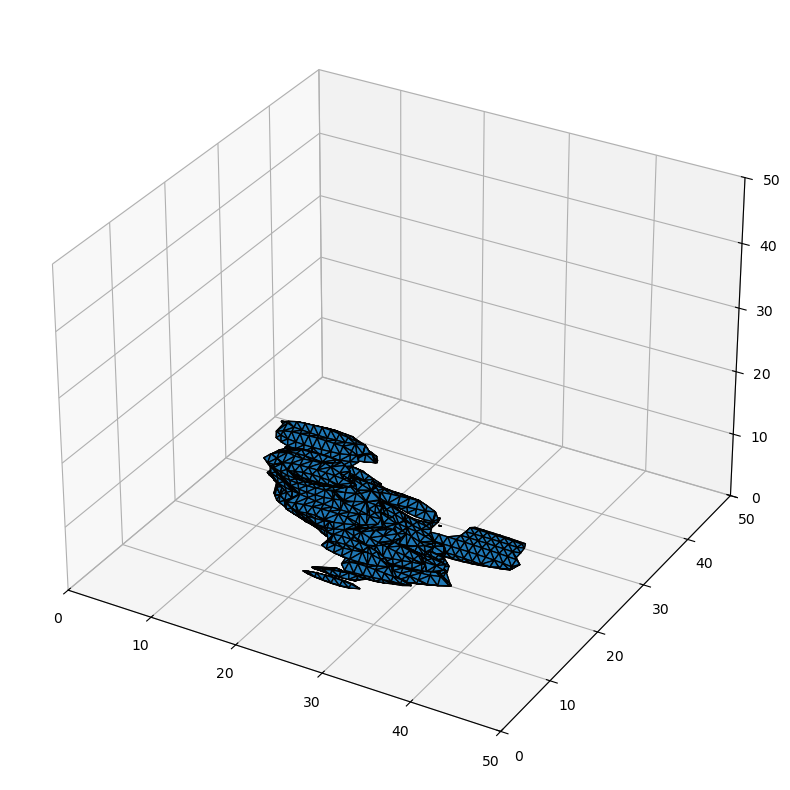

In [160]:
mesh = Poly3DCollection(verts[faces])

mesh.set_edgecolor('k')
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
ax.add_collection3d(mesh)

#ax.set_xlabel("x-axis: a = 6 per ellipsoid")
#ax.set_ylabel("y-axis: b = 10")
#ax.set_zlabel("z-axis: c = 16")
ax.set_xlim(0, 50)  # a = 6 (times two for 2nd ellipsoid)
ax.set_ylim(0, 50)  # b = 10
ax.set_zlim(0, 50)  # c = 16

#plt.tight_layout()
#plt.show()


In [121]:
newImage_foxa2.shape

(49, 47, 41)

(0.0, 50.0)

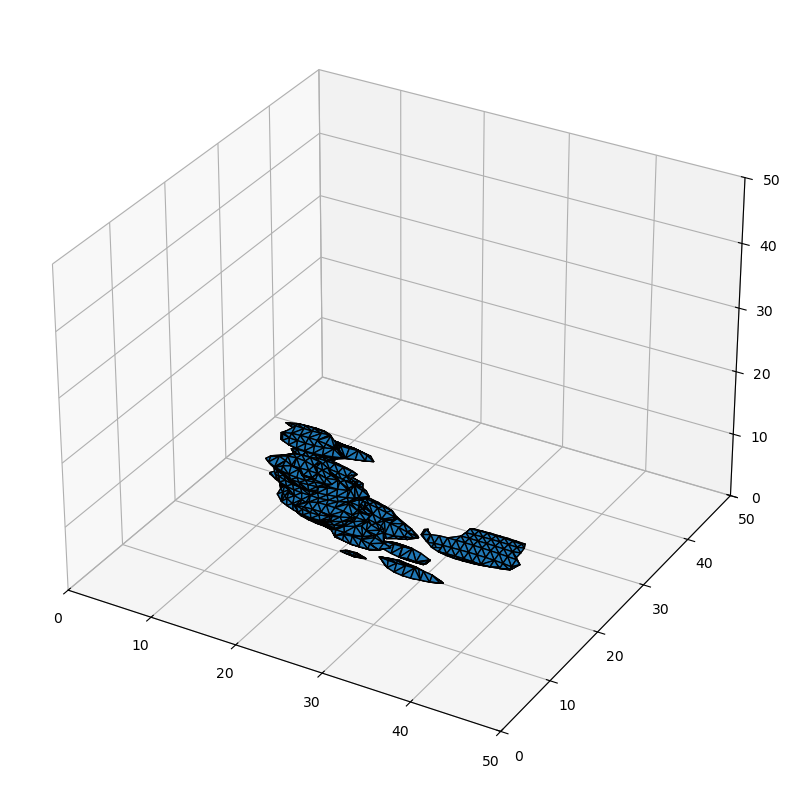

In [21]:
import napari
from napari.utils import nbscreenshot

In [18]:
## test marching cube algorith from scikit image 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from skimage import measure
from skimage.draw import ellipsoid

# Generate a level set about zero of two identical ellipsoids in 3D
ellip_base = ellipsoid(6, 10, 16, levelset=True)
ellip_double = np.concatenate((ellip_base[:-1, ...], ellip_base[2:, ...]), axis=0)

In [22]:
ellip_double.shape
#ellip_base.shape

(27, 23, 35)

In [24]:
viewer = napari.Viewer()
# show images
viewer.add_image(cle.pull(ellip_base))

<Image layer 'ellip_base' at 0x2b79c77c0>

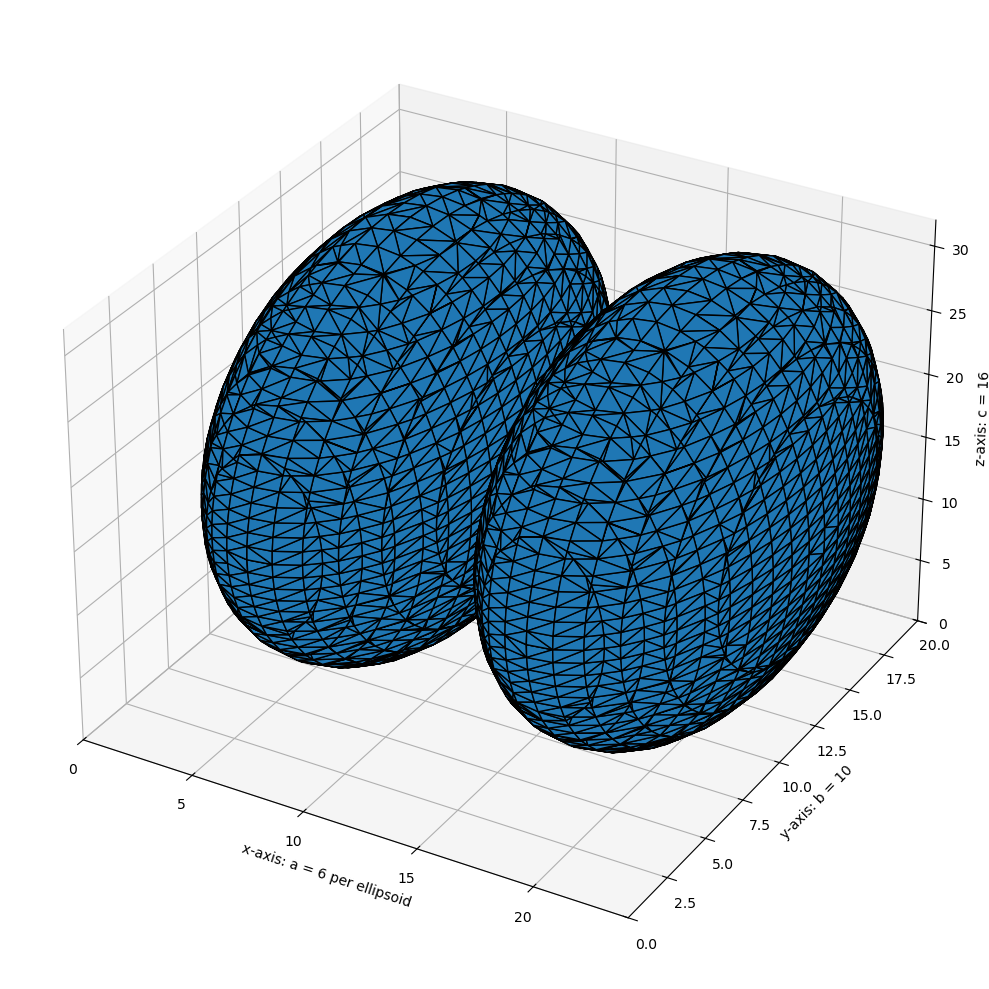

In [35]:
# Use marching cubes to obtain the surface mesh of these ellipsoids
verts, faces, normals, values = measure.marching_cubes(ellip_double, 0)

# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes docstring).
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

ax.set_xlabel("x-axis: a = 6 per ellipsoid")
ax.set_ylabel("y-axis: b = 10")
ax.set_zlabel("z-axis: c = 16")

ax.set_xlim(0, 24)  # a = 6 (times two for 2nd ellipsoid)
ax.set_ylim(0, 20)  # b = 10
ax.set_zlim(0, 32)  # c = 16

plt.tight_layout()
plt.show()


(20156,)

<Labels layer 'labels_mask' at 0x324cd2a90>

In [1]:
import numpy as np

from dipy.core.sphere import HemiSphere, Sphere, disperse_charges
from dipy.data import get_sphere
from dipy.reconst.shm import sf_to_sh, sh_to_sf
from dipy.sims.voxel import multi_tensor_odf


/Users/jingkui.wang/miniforge3/envs/image_env/lib/python3.9/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
from dipy.viz import actor, window

In [3]:
rng = np.random.default_rng()
n_pts = 64
theta = np.pi * rng.random(n_pts)
phi = 2 * np.pi * rng.random(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)


In [4]:
hsph_updated, potential = disperse_charges(hsph_initial, 5000)
sphere = Sphere(xyz=np.vstack((hsph_updated.vertices, -hsph_updated.vertices)))


In [5]:
mevals = np.array([[0.0015, 0.00015, 0.00015], [0.0015, 0.00015, 0.00015]])
angles = [(0, 0), (60, 0)]
odf = multi_tensor_odf(sphere.vertices, mevals, angles, [50, 50])

# Enables/disables interactive visualization
interactive = False

scene = window.Scene()
scene.SetBackground(1, 1, 1)

odf_actor = actor.odf_slicer(odf[None, None, None, :], sphere=sphere)
odf_actor.RotateX(90)
scene.add(odf_actor)

print("Saving illustration as symm_signal.png")
window.record(scene=scene, out_path="symm_signal.png", size=(300, 300))
if interactive:
    window.show(scene)

Saving illustration as symm_signal.png


In [6]:
# Change this value to try out other bases
sh_basis = "descoteaux07"
# Change this value to try other maximum orders
sh_order_max = 8

sh_coeffs = sf_to_sh(odf, sphere, sh_order_max=sh_order_max, basis_type=sh_basis)


In [7]:
high_res_sph = get_sphere(name="symmetric724").subdivide(n=2)
reconst = sh_to_sf(
    sh_coeffs, high_res_sph, sh_order_max=sh_order_max, basis_type=sh_basis
)

scene.clear()
odf_actor = actor.odf_slicer(reconst[None, None, None, :], sphere=high_res_sph)
odf_actor.RotateX(90)
scene.add(odf_actor)

print("Saving output as symm_reconst.png")
window.record(scene=scene, out_path="symm_reconst.png", size=(300, 300))
if interactive:
    window.show(scene)

Saving output as symm_reconst.png


In [8]:
mevals = np.array([[0.0015, 0.0003, 0.0003]])
angles = [(0, 0)]
odf2 = multi_tensor_odf(sphere.vertices, mevals, angles, [100])

n_pts_hemisphere = int(sphere.vertices.shape[0] / 2)
asym_odf = np.append(odf[:n_pts_hemisphere], odf2[n_pts_hemisphere:])

scene.clear()
odf_actor = actor.odf_slicer(asym_odf[None, None, None, :], sphere=sphere)
odf_actor.RotateX(90)
scene.add(odf_actor)

print("Saving output as asym_signal.png")
window.record(scene=scene, out_path="asym_signal.png", size=(300, 300))
if interactive:
    window.show(scene)

Saving output as asym_signal.png


In [9]:
sh_coeffs = sf_to_sh(asym_odf, sphere, sh_order_max=sh_order_max, basis_type=sh_basis)
reconst = sh_to_sf(
    sh_coeffs, high_res_sph, sh_order_max=sh_order_max, basis_type=sh_basis
)

scene.clear()
odf_actor = actor.odf_slicer(reconst[None, None, None, :], sphere=high_res_sph)
odf_actor.RotateX(90)
scene.add(odf_actor)

print("Saving output as asym_reconst.png")
window.record(scene=scene, out_path="asym_reconst.png", size=(300, 300))
if interactive:
    window.show(scene)

Saving output as asym_reconst.png


In [10]:
sh_coeffs = sf_to_sh(
    asym_odf, sphere, sh_order_max=sh_order_max, basis_type=sh_basis, full_basis=True
)
reconst = sh_to_sf(
    sh_coeffs,
    high_res_sph,
    sh_order_max=sh_order_max,
    basis_type=sh_basis,
    full_basis=True,
)

scene.clear()
odf_actor = actor.odf_slicer(reconst[None, None, None, :], sphere=high_res_sph)
odf_actor.RotateX(90)
scene.add(odf_actor)

print("Saving output as asym_reconst_full.png")
window.record(scene=scene, out_path="asym_reconst_full.png", size=(300, 300))
if interactive:
    window.show(scene)

Saving output as asym_reconst_full.png
